# Predicting german words using tsBERT (TongueSwitcher)

## Data reading

In [90]:
import json

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F
from torch.nn.functional import softmax

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [363]:
with open('data/chall_ml4sci_1.0.json') as f:
    file_content = f.read()
    
parsed_content = json.loads(file_content)

In [364]:
print(parsed_content.keys())
print(parsed_content['corpus'])
print(parsed_content['system'])
print(parsed_content['version'])

dict_keys(['corpus', 'system', 'version', 'records'])
{'identifier': 'chall_data'}
{'name': 'jonatasgrosman/wav2vec2-xls-r-1b-english'}
ml4sci_1.0


In [365]:
# get the records
records = parsed_content['records']
records[0]

{'human_transcript': 'hello my name is casper what is your name',
 'stt_transcript': 'how my name is casper what is your name',
 'words': [{'human_word': 'hello', 'stt_word': 'how'},
  {'human_word': 'my', 'stt_word': 'my'},
  {'human_word': 'name', 'stt_word': 'name'},
  {'human_word': 'is', 'stt_word': 'is'},
  {'human_word': 'casper', 'stt_word': 'casper'},
  {'human_word': 'what', 'stt_word': 'what'},
  {'human_word': 'is', 'stt_word': 'is'},
  {'human_word': 'your', 'stt_word': 'your'},
  {'human_word': 'name', 'stt_word': 'name'}]}

### Quick Data Exploration

In [366]:
print(f"There are {len(records)} records in total.")

There are 6723 records in total.


In [367]:
nb_words_per_record = [len(record['words']) for record in records]

In [368]:
print(f"The minimum number of words in any transcript is {min(nb_words_per_record)}.")
print(f"The maximum number of words in any transcript is {max(nb_words_per_record)}.")
print(f"The median number of words across all transcripts is {int(np.median(nb_words_per_record))}.")

The minimum number of words in any transcript is 1.
The maximum number of words in any transcript is 517.
The median number of words across all transcripts is 6.


<Figure size 600x400 with 0 Axes>

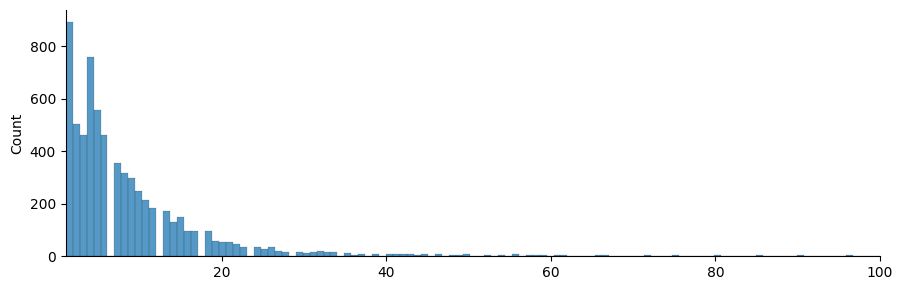

In [369]:
# plot the distribution of word counts
plt.figure(figsize=(6, 4))
sns.displot(nb_words_per_record, orientation='horizontal', height=3, aspect=3)
plt.xlim(1, 100)
plt.show()

## Data Preprocessing and Data Labelling

In [370]:
# get human and stt transcripts from records
stt_transcripts = [record['stt_transcript'] for record in records]
human_transcripts = [record['human_transcript'] for record in records]

In [371]:
# initialize empty lists to store tokenized human transcripts, tokenized STT transcripts, and labels
human_tokenized_transcripts = []
stt_tokenized_transcripts = []
labels = []

for record in records:
    
    record_human_words = []
    record_stt_words = []
    record_labels = []
    
    for word in record['words']:
        
        # check if the word in the human transcript is labelled as german
        if '@g' in word['human_word']:
            # if it contains '@g', label it as 1 and remove '@g' from the word
            record_human_words.append(word['human_word'].replace('@g', ''))
            record_labels.append(1)
        else:
            record_human_words.append(word['human_word'])
            record_labels.append(0)
            
        record_stt_words.append(word['stt_word'])
        
    human_tokenized_transcripts.append(record_human_words)
    stt_tokenized_transcripts.append(record_stt_words)
    labels.append(record_labels)

In [372]:
# load the tsBERT model and the tokenizer
model_name = "igorsterner/german-english-code-switching-identification"
model = AutoModelForTokenClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

### Incorporating Artificial Data

=> TO DO

### Transcripts Processing
--> how individual records are prepared for BERT

In [373]:
def create_contextual_input_with_labels(transcripts, labels, window_size=1, sep_token='[SEP]'):
    """
    Create contextual input with labels, setting labels of context to -100.

    Args:
        transcripts (list of list of str): List of tokenized transcripts.
        labels (list of list of int): List of labels for each transcript.
        window_size (int): Size of the context window.
        sep_token (str): Token used for separating sentences.

    Returns:
        tuple: Tuple containing modified transcripts and their corresponding labels.
    """
    if window_size == 0:
        return transcripts, labels

    contextual_transcripts = []
    contextual_labels = []

    for i, (transcript, label) in enumerate(zip(transcripts, labels)):
        # concatenate previous, current, and next transcripts within the window size
        start_idx = max(i - window_size, 0)
        end_idx = min(i + window_size + 1, len(transcripts))
        
        # prepare new transcript and labels
        new_transcript = []
        new_label = []

        for j in range(start_idx, end_idx):
            # intersperse the transcript with defined separator tokens ('.', [SEP], ...)
            new_transcript.extend(transcripts[j] + [sep_token])
            # extend labels with -100 for context transcripts, retain original for current
            new_label.extend([-100] * len(transcripts[j]) if j != i else labels[j])
            new_label.append(-100)  # for the SEP token

        new_transcript.pop()  # remove the last SEP token
        new_label.pop()       # remove the last label

        contextual_transcripts.append(new_transcript)
        contextual_labels.append(new_label)

    return contextual_transcripts, contextual_labels

In [374]:
def preprocess_labels(tokenized_inputs, input_labels):
    """
    Preprocess labels based on tsBERT tokenization.

    Args:
        tokenized_inputs (transformers.TokenizerOutput): Tokenized inputs.
        input_labels (list): Original labels for each input.

    Returns:
        list: Preprocessed labels for each tokenized input.
    """
    tsBERT_labels = []

    for i, _ in enumerate(tokenized_inputs.input_ids):
        # get the word indices from original inputs
        word_indices = tokenized_inputs.word_ids(batch_index=i)
        # get the labels of the current record
        record_labels = input_labels[i]
        # initialize a list to store the new labels for this record
        new_record_labels = []

        for word_idx in word_indices:
            # check if the word index is None => indicates a special token (e.g., [CLS], [SEP], [PAD])
            if word_idx is None:
                new_record_labels.append(-100)
            # otherwise, retrieve the label corresponding to this word index from the record labels
            else:
                new_record_labels.append(record_labels[word_idx])

        tsBERT_labels.append(new_record_labels)

    return tsBERT_labels

In [388]:
# select the window size
window_size = 1

# compute the contextual input with labels
contextual_stt_input, contextual_labels = create_contextual_input_with_labels(stt_tokenized_transcripts, labels, window_size=window_size)

In [389]:
# tokenize the STT-transcribed transcripts using the BERT tokenizer
tokenized_inputs = tokenizer(contextual_stt_input[:5], truncation=True, padding=True, is_split_into_words=True)

### Label Alignement
- we adjust the labels: since we add context (neighbour transcripts) and [SEP] tokens as input the the model, we also also need to adjust out labels to align with the new token structure.
- we assign an ignore index (-100) to these separator tokens since they don't carry meaningful language labels.

In [390]:
# align the labels so that they are suitable for the tsBERT model
tsBERT_labels = preprocess_labels(tokenized_inputs, contextual_labels)

In [391]:
#for i, tuple_ in enumerate(zip(tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][2]), tokenized_inputs.word_ids(batch_index=2), preprocess_labels(tokenized_inputs, contextual_labels)[2])):
#    print(tuple_)

### Homophone-Enriched Sentences

=> TO DO

## Train-Test-Validation Split

In [392]:
stt_tokenized_transcripts

[['how', 'my', 'name', 'is', 'casper', 'what', 'is', 'your', 'name'],
 ['lo', 'i', 'name', 'is', '', 'picacho'],
 ['a', 'very', 'nice', 'name', 'what', 'have', 'you', 'for', 'hobbies'],
 ['me', 'hobbes', 'is', 'fotball', 'and', 'me', 'hobby'],
 ['that',
  'is',
  'very',
  'nice',
  'my',
  'hobby',
  'is',
  'too',
  'football',
  'who',
  'my',
  'favorite',
  'foot',
  'is',
  'insect',
  'and',
  'you'],
 ['my', 'fame read', 'foot', 'spezza'],
 ['him', 'where', 'are', 'live', 'you'],
 ['i', 'live', 'roaming'],
 ['i', 'live', 'in', 'takatukalan'],
 ['golf'],
 ['what', 'love s', 'you'],
 ['walling', 'and'],
 ['coo like', '', 'chance', 'collars', 'and', 'i', 'hearts', 'swimming'],
 ['i', 'had', 'plumpy'],
 ['oh'],
 ['if',
  'you',
  'could',
  'be',
  'an',
  'animal',
  'for',
  'a',
  'day',
  'which',
  'one',
  'would',
  'you',
  'like',
  'to',
  'be'],
 ['i', 'be', 'a', 'bird'],
 ['why', 'a', 'birt'],
 ['then',
  'i',
  'can',
  'fly',
  'what',
  'would',
  'you',
  'do',
  'i

In [ ]:
# create a validation set for evaluation and tuning
train_records, val_records, train_labels, val_labels = train_test_split(stt_tokenized_transcripts, labels, test_size=.2)

## tsBERT Fine-tuning

### Hyperparameter Tuning

### Test Set Evaluation

## Initial Data Exploration

- check proportion of english-german words in the speech-to-text (stt) transcripts
- check position of german words in stt transcripts

In [413]:
# get human and stt transcripts from records
stt_transcripts = [record['stt_transcript'] for record in records]
human_transcripts = [record['human_transcript'] for record in records]

In [414]:
# initialize empty lists to store tokenized human transcripts, tokenized STT transcripts, and labels
human_tokenized_transcripts = []
stt_tokenized_transcripts = []
labels = []

for record in records:
    
    record_human_words = []
    record_stt_words = []
    record_labels = []
    
    for word in record['words']:
        
        # check if the word in the human transcript is labelled as german
        if '@g' in word['human_word']:
            # if it contains '@g', label it as 1 and remove '@g' from the word
            record_human_words.append(word['human_word'].replace('@g', ''))
            record_labels.append(1)
        else:
            record_human_words.append(word['human_word'])
            record_labels.append(0)
            
        record_stt_words.append(word['stt_word'])
        
    human_tokenized_transcripts.append(record_human_words)
    stt_tokenized_transcripts.append(record_stt_words)
    labels.append(record_labels)

### Predictions using raw model

In [7]:
import transformers
#from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification

import torch
import torch.nn.functional as F
from torch.nn.functional import softmax

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [8]:
# load the tsBERT model and the tokenizer
model_name = "igorsterner/german-english-code-switching-identification"
model = AutoModelForTokenClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [415]:
def preprocess_labels(tokenized_inputs, input_labels):
    """
    Preprocess labels based on tsBERT tokenization.

    Args:
        tokenized_inputs (transformers.TokenizerOutput): Tokenized inputs.
        input_labels (list): Original labels for each input.

    Returns:
        list: Preprocessed labels for each tokenized input.
    """
    tsBERT_labels = []

    for i, _ in enumerate(tokenized_inputs.input_ids):
        # Get the word indices from original inputs
        word_indices = tokenized_inputs.word_ids(batch_index=i)
        # Get the labels of the current record
        record_labels = input_labels[i]
        # Initialize a list to store the new labels for this record
        new_record_labels = []

        for word_idx in word_indices:
            # Check if the word index is None => indicates a special token (e.g., [CLS], [SEP], [PAD])
            if word_idx is None:
                new_record_labels.append(-100)
            # Otherwise, retrieve the label corresponding to this word index from the record labels
            else:
                new_record_labels.append(record_labels[word_idx])

        tsBERT_labels.append(new_record_labels)

    return tsBERT_labels

In [416]:
# tokenize the STT-transcribed transcripts using the BERT tokenizer
tokenized_inputs = tokenizer(stt_tokenized_transcripts, truncation=True, padding=True, is_split_into_words=True)
#input_labels = labels
tsBERT_labels = preprocess_labels(tokenized_inputs, labels)

In [11]:
# convert the tokenized inputs to PyTorch tensors
input_ids = torch.tensor(tokenized_inputs['input_ids'])
attention_mask = torch.tensor(tokenized_inputs['attention_mask'])

In [ ]:
# perform a forward pass to get model predictions
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    
logits = outputs.logits

In [ ]:
# Apply softmax to convert logits to probabilities
probabilities = F.softmax(logits, dim=-1)

# process the predictions
predictions = []

# iterate over each record
for i, record_logits in enumerate(logits):
    #print(f"Record {i+1} Predictions:")
    
    # retrieve the tokens for this record
    token_ids = tokenized_inputs['input_ids'][i]
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    
    # retrieve the probas
    record_probs = probabilities[i]
    record_predictions = []

    # iterate over each token
    for token, token_probs in zip(tokens, record_probs):
        
        if (token == '[PAD]') or (token == '[CLS]') or (token == '[SEP]'):
            continue
            
        # get the most probable class and its score for this token
        max_idx = torch.argmax(token_probs).item()
        max_prob = token_probs[max_idx].item()
        
        #label_mapping = {0: 'D', 1: 'E', 2: 'SD', 3: 'SE', 4: 'SO', 5: 'O', 6: 'M'}
        #print(f"{token} : {label_mapping.get(max_idx)} - Score: {max_prob:.4f}")
        
        record_predictions.append([model.config.id2label[max_idx], max_prob])
        #print(f"{token} : {model.config.id2label[max_idx]}  --  score : {max_prob:.4f}")
        #print(f"{token_probs}")
        
    predictions.append(record_predictions)
    #print("\n")

In [ ]:
# flatten the predictions and convert them to binary format
predicted_labels = [0 if pred[0] == 'E' else 1 for record_predictions in predictions for pred in record_predictions]
flattened_tsBERT_labels = [label for record_labels in tsBERT_labels for label in record_labels if label != -100 ]

# ensure that true and predicted labels are correctly aligned
if len(predicted_labels) != len(flattened_tsBERT_labels):
    raise ValueError("The length of predicted labels and true labels must be the same.")

In [ ]:
# compute evaluation metrics
accuracy = accuracy_score(flattened_tsBERT_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(flattened_tsBERT_labels, predicted_labels, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

### Fine-tuning tsBERT (TongueSwitcher)

In [13]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [14]:
# create a validation set for evaluation and tuning
train_records, val_records, train_labels, val_labels = train_test_split(stt_tokenized_transcripts, labels, test_size=.2)

In [15]:
train_encodings = tokenizer(train_records, truncation=True, padding=True, is_split_into_words=True)
val_encodings = tokenizer(val_records, truncation=True, padding=True, is_split_into_words=True)
#test_encodings = tokenizer(test_records, truncation=True, padding=True)

train_labels = preprocess_labels(train_encodings, train_labels)
val_labels = preprocess_labels(val_encodings, val_labels)

In [17]:
class SttDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [18]:
# convert tokenized inputs and tsBERT_labels into datasets
# or tsBERT_labels train_dataset = CustomDataset(tokenized_inputs, tsBERT_labels)
train_dataset = SttDataset(train_encodings, train_labels)
val_dataset = SttDataset(val_encodings, val_labels)
#test_dataset = SttDataset(test_encodings, test_labels)

In [19]:
# define a DataLoader to help in loading the data in batches during training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [21]:
# define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_function = CrossEntropyLoss(ignore_index=-100)

In [22]:
# train the model
num_epochs = 5

model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch in tqdm(train_loader):
        # clear previous gradients
        optimizer.zero_grad()
        
        # forward pass
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        # compute loss and backpropagate
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|███████████████████████████████████████| 337/337 [8:01:29<00:00, 85.73s/it]


Epoch 1/5, Loss: 0.17613139188536153


100%|███████████████████████████████████████| 337/337 [1:51:56<00:00, 19.93s/it]


Epoch 2/5, Loss: 0.10283842084940402


100%|███████████████████████████████████████| 337/337 [1:07:36<00:00, 12.04s/it]


Epoch 3/5, Loss: 0.06749159054870742


100%|███████████████████████████████████████| 337/337 [3:14:20<00:00, 34.60s/it]


Epoch 4/5, Loss: 0.043880257700073866


100%|███████████████████████████████████████| 337/337 [1:24:15<00:00, 15.00s/it]

Epoch 5/5, Loss: 0.03331470468067025


In [23]:
#model.save_pretrained('./finetuned_tsbert_lr_5e5')
#tokenizer.save_pretrained('./finetuned_tsbert_lr_5e5')

('./finetuned_tsbert_lr_5e5/tokenizer_config.json',
 './finetuned_tsbert_lr_5e5/special_tokens_map.json',
 './finetuned_tsbert_lr_5e5/vocab.txt',
 './finetuned_tsbert_lr_5e5/added_tokens.json',
 './finetuned_tsbert_lr_5e5/tokenizer.json')

#### Evaluating

In [394]:
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # batch size can be adjusted

In [404]:
# put model in evaluation mode
model.eval()

# initialize lists to store predictions and true labels
true_labels = []
predictions = []

# disable gradient calculation
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        # forward pass, get predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        
        logits = outputs.logits
        
        # Apply softmax to convert logits to probabilities
        probabilities = F.softmax(logits, dim=-1)
        
        # iterate over each record
        for i, record_logits in enumerate(logits):
            
            # retrieve the tokens for this record
            token_ids = input_ids[i]
            tokens = tokenizer.convert_ids_to_tokens(token_ids)

            # retrieve the probas
            record_probs = probabilities[i]
            record_predictions = []

            # iterate over each token
            for token, token_probs in zip(tokens, record_probs):

                if (token == '[PAD]') or (token == '[CLS]') or (token == '[SEP]'):
                    continue

                # get the most probable class and its score for this token
                max_idx = torch.argmax(token_probs).item()
                max_prob = token_probs[max_idx].item()

                record_predictions.append([model.config.id2label[max_idx], max_prob])

            predictions.append(record_predictions)

In [423]:
len(predictions)

1345

In [432]:
predictions[0]

[['E', 0.9991375207901001],
 ['E', 0.9993659853935242],
 ['E', 0.999072790145874],
 ['E', 0.463546484708786],
 ['E', 0.7066754698753357],
 ['E', 0.7981131076812744],
 ['E', 0.9648026823997498]]

In [419]:
flattened_tsBERT_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [433]:
# flatten the predictions and convert them to binary format
predicted_labels = [0 if pred[0] == 'E' else 1 for record_predictions in predictions for pred in record_predictions]
flattened_tsBERT_labels = [label for record_labels in val_labels for label in record_labels if label != -100 ]

# ensure that true and predicted labels are correctly aligned
if len(predicted_labels) != len(flattened_tsBERT_labels):
    raise ValueError("The length of predicted labels and true labels must be the same.")

In [434]:
# compute evaluation metrics
accuracy = accuracy_score(flattened_tsBERT_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(flattened_tsBERT_labels, predicted_labels, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9307
Precision: 0.1296
Recall: 0.1677
F1 Score: 0.1462


In [ ]:
# check the proportion of german-labelled words in records containing at least one german word
prop_german = []
for record_labels in labels:
    if 1 in record_labels:
        prop_german.append(record_labels.count(1) / len(record_labels))